In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import copy
from math import sqrt,ceil
from scipy.stats import linregress

In [6]:
directory = "../../OneDrive - HvA/Logfiles/H2A/2022/20220628-20220701_race_nogaro/0023 - 20220701T141014 1h8m8s 13.336km Nogaro/"

file = "2.csv"
#
column_names_motor_driver = ['Datalogger port', 'Datalogger tijd (s)', 'Format header (>03|04)', 'Tijd sinds laatste herstart motordriver (s)',
    'Spanning over de motor (V)', 'Stroom door de motor (A)', 'Vermogen geleverd aan de motor (W)',
    'Energie geleverd aan de motor sinds reset (J)', 'Spanning ingang motordriver (V)', 'Stroom ingang motordriver (A)',
    'Vermogen geleverd aan de motordriver (W)', 'Energie geleverd aan de motordriver sinds reset (J)', 'Motordriver temperatuur (C)', 'Motordriver-bord temperatuur (C)', 'Duty cycle motordriver (%)',
    'Wielsnelheid (km/h)', 'Afgelegde afstand sinds laatste herstart (m)', 'Laatste correcte interval snelheidssensor (s)','Laatste correcte edge snelheidssensor (s)', 'Toestand Full Power knop (aan=1 uit=0)','Tijdstip laatste verandering Full Power knop (s)', 'Toestand CruiseControl knop (aan=1 uit=0)','Tijdstip laatste verandering CruiseControl (s)', 'Huidig stroom-instelpunt cruise control',
    'Doelsnelheid cruise control (km/h)', 'Toestand cruise control2-knop (aan=1 uit=0)',
    'Tijdstip laatste verandering cruise control2-knop', 'GPS longitude (graden)', 'GPS latitude (graden)','GPS direction', 'GPS speed (km/h)', 'GPS time (seconden sinds begin GPS-week)', 'Checksum']

column_names_fcc_protector = [
    'Datalogger port', 'Dataloggertijd (s)', 'Formatheader (>13|01)', 'Tijd sinds boot (s)',
    'Fuelcell spanning (V)', 'Fuelcell stroom (A)', 'Fuelcell vermogen (W)', 'Fuelcell totaal geleverde lading (C)',
    'Fuelcell totaal geleverde energie (J)', 'Supercap spanning (V)', 'Supercap stroom (A)', 'Supercap vermogen (W)',
    'Supercap totaal geleverde lading (C)', 'Supercap totaal geleverde energie (J)', '3v3 stroom (A)',
    '3v3 lading (C)', '5v stroom (A)', '5v lading (C)', '12v stroom (A)', '12v lading (C)', '24v stroom (A)',
    '24v lading (C)', 'Racemode?', 'Shiftregister state', 'Compressor dutycycle (%)', 'Compressor pulses',
    'Stoichiometry', 'Flowsensor interval (ms)', 'Average flow (sccm)', 'Cumulatieve flow (scc)', 'Flowmeter tijd (s)',
    'Flow valid', 'Temperatuur 1 (C)', 'Thermocouple 1 cold junction (C)', 'Thermocouple 1 status',
    'Temperatuur 2 (C)', 'Thermocouple 2 cold junction (C)', 'Thermocouple 2 status', 'Temperatuur 3 (C)',
    'Thermocouple 3 cold junction (C)', 'Thermocouple 3 status', 'Gemiddelde temperatuur (C)', 'Druk (mbar)', 'Checksum'
]

column_names_master_h2a = [
    'Datalogger port', 'Dataloggertijd (s)', 'Format header (>08|03)', 'NMEA type ($GPRMC)', 'Tijd (UU/MM/SS,...)','Status (A)', 'Latitude', 'Noord of Zuid (N/S)', 'Longitude', 'Oost of West (E/W)',
    'Snelheid over de grond (km/h)', 'Richting van de snelheid', 'Datum (dd/mm/jj)', 'Magnetische variatie',
    'Magnetische directie', 'Mode indicator (A)', 'Data in balancers (1 als data)', 'DegreesTrue', 'T',
    'DegreesMagnetic', 'M', 'Snelheid t.o.v. het water (Knots)', 'N', 'Snelheid t.o.v. het water (Kilometers)', 'K'
]

In [7]:
import os
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Basis pad voor de OneDrive locatie
directory = "../../OneDrive - HvA/Logfiles/"  # Vul hier je eigen pad naar je OneDrive map in

# Dropdown widgets voor elke stap
voertuig_dropdown = widgets.Dropdown(description='Voertuig:')
jaartal_dropdown = widgets.Dropdown(description='Jaartal:')
situatie_dropdown = widgets.Dropdown(description='Situatie:')
dataset_dropdown = widgets.Dropdown(description='Dataset:')
file_dropdown = widgets.Dropdown(description='Bestand:')

# Confirm-knop
confirm_button = widgets.Button(description="Confirm")

# Output widget voor berichten of fouten
output = widgets.Output()

def update_jaartal_options(change):
    """Update de jaartal dropdown op basis van het gekozen voertuig."""
    selected_voertuig = voertuig_dropdown.value
    voertuig_path = os.path.join(directory, selected_voertuig)
    
    if os.path.exists(voertuig_path):
        # Lijst van beschikbare jaartallen (mappen) in de voertuigmap
        jaartal_options = [name for name in os.listdir(voertuig_path) if os.path.isdir(os.path.join(voertuig_path, name))]
        jaartal_dropdown.options = jaartal_options
    else:
        jaartal_dropdown.options = []
        situatie_dropdown.options = []
        dataset_dropdown.options = []
        file_dropdown.options = []

def update_situatie_options(change):
    """Update de situatie dropdown op basis van het gekozen jaartal."""
    selected_voertuig = voertuig_dropdown.value
    selected_jaartal = jaartal_dropdown.value
    jaartal_path = os.path.join(directory, selected_voertuig, selected_jaartal)
    
    if os.path.exists(jaartal_path):
        # Lijst van beschikbare situaties (mappen) in de jaartalmap
        situatie_options = [name for name in os.listdir(jaartal_path) if os.path.isdir(os.path.join(jaartal_path, name))]
        situatie_dropdown.options = situatie_options
    else:
        situatie_dropdown.options = []
        dataset_dropdown.options = []
        file_dropdown.options = []

def update_dataset_options(change):
    """Update de dataset dropdown op basis van de gekozen situatie."""
    selected_voertuig = voertuig_dropdown.value
    selected_jaartal = jaartal_dropdown.value
    selected_situatie = situatie_dropdown.value
    situatie_path = os.path.join(directory, selected_voertuig, selected_jaartal, selected_situatie)
    
    if os.path.exists(situatie_path):
        # Lijst van beschikbare datasets (mappen) in de situatiemap
        dataset_options = [name for name in os.listdir(situatie_path) if os.path.isdir(os.path.join(situatie_path, name))]
        dataset_dropdown.options = dataset_options
    else:
        dataset_dropdown.options = []
        file_dropdown.options = []

def update_file_options(change):
    """Update de file dropdown op basis van de gekozen dataset."""
    selected_voertuig = voertuig_dropdown.value
    selected_jaartal = jaartal_dropdown.value
    selected_situatie = situatie_dropdown.value
    selected_dataset = dataset_dropdown.value
    dataset_path = os.path.join(directory, selected_voertuig, selected_jaartal, selected_situatie, selected_dataset)
    
    if os.path.exists(dataset_path):
        # Lijst van beschikbare bestanden in de datasetmap
        file_options = [name for name in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, name))]
        file_dropdown.options = file_options
    else:
        file_dropdown.options = []

def read_file(b):
    """Leest het gekozen bestand en toont de inhoud."""
    selected_voertuig = voertuig_dropdown.value
    selected_jaartal = jaartal_dropdown.value
    selected_situatie = situatie_dropdown.value
    selected_dataset = dataset_dropdown.value
    selected_file = file_dropdown.value
    file_path = os.path.join(directory, selected_voertuig, selected_jaartal, selected_situatie, selected_dataset, selected_file)
    
    if os.path.exists(file_path):
        try:
            # Lees het bestand (bijvoorbeeld een CSV)
            df = pd.read_csv(file_path, delimiter=',', names=column_names_motor_driver, header=None, encoding='latin1', comment="#", on_bad_lines='skip')
            with output:
                output.clear_output()
                print(f"Bestandsinhoud van {file_path}:")
                display(df)
        except Exception as e:
            with output:
                output.clear_output()
                print(f"Fout bij het inlezen van het bestand: {e}")
    else:
        with output:
            output.clear_output()
            print("Bestand niet gevonden.")

# Verbind de veranderingen in de dropdowns aan hun respectievelijke update functies
voertuig_dropdown.observe(update_jaartal_options, names='value')
jaartal_dropdown.observe(update_situatie_options, names='value')
situatie_dropdown.observe(update_dataset_options, names='value')
dataset_dropdown.observe(update_file_options, names='value')

# Koppel de 'Confirm'-knop aan de read_file functie (deze voert de actie pas uit na het klikken)
confirm_button.on_click(read_file)

# Begin met het ophalen van de voertuigen (eerste dropdown)
voertuig_dropdown.options = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]

# Toon de widgets
display(voertuig_dropdown, jaartal_dropdown, situatie_dropdown, dataset_dropdown, file_dropdown, confirm_button, output)


Dropdown(description='Voertuig:', options=('EVA', 'gnuplot voorbeelden', 'H2A', 'Oude data datalogger boot', '…

Dropdown(description='Jaartal:', options=(), value=None)

Dropdown(description='Situatie:', options=(), value=None)

Dropdown(description='Dataset:', options=(), value=None)

Dropdown(description='Bestand:', options=(), value=None)

Button(description='Confirm', style=ButtonStyle())

Output()

In [18]:
#data = np.genfromtxt(f'{directory}{file}', delimiter=',', dtype=None, encoding='latin1', filling_values=np.NaN)

# Data inladen direct als DataFrame en kolomnamen aanpassen
df = pd.read_csv(f'{directory}{file}', delimiter=',', names=column_names_motor_driver, header=None, encoding='latin1', comment="#")

In [19]:
#df.insert(0, 'Index', range(1, len(df) + 1))

In [20]:
df

,Datalogger port,Datalogger tijd (s),Format header (>03|04),Tijd sinds laatste herstart motordriver (s),Spanning over de motor (V),Stroom door de motor (A),Vermogen geleverd aan de motor (W),Energie geleverd aan de motor sinds reset (J),Spanning ingang motordriver (V),Stroom ingang motordriver (A),...,Huidig stroom-instelpunt cruise control,Doelsnelheid cruise control (km/h),Toestand cruise control2-knop (aan=1 uit=0),Tijdstip laatste verandering cruise control2-knop,GPS longitude (graden),GPS latitude (graden),GPS direction,GPS speed (km/h),GPS time (seconden sinds begin GPS-week),Checksum
0,2,503.5680,03|04,0.0010,0.395,0.001,0.0,0,0.451,0.002,...,0,0.0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
1,2,503.5736,03|04,0.0060,1.948,0.004,0.1,0,2.225,0.011,...,0,0.0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
2,2,503.5792,03|04,0.0116,3.528,0.007,0.1,0,4.026,0.023,...,0,0.0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
3,2,503.5848,03|04,0.0172,4.954,0.009,0.2,0,5.650,0.031,...,0,0.0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,2,503.5904,03|04,0.0228,6.241,0.011,0.2,0,7.116,0.043,...,0,0.0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244089,2,2560.8613,03|04,2056.9358,0.041,0.103,0.0,129358,9.708,0.017,...,7,15.0,0,2044.28100002.4427,4346.2507,328.0,0.0,124942.0,NaN,NaN
244090,2,2560.8698,03|04,2056.9443,0.040,0.110,0.0,129358,9.301,0.026,...,7,15.0,0,2044.28100002.4427,4346.2507,328.0,0.0,124942.0,NaN,NaN
244091,2,2560.8783,03|04,2056.9529,0.040,0.118,0.0,129358,8.885,0.031,...,7,15.0,0,2044.28100002.4427,4346.2507,328.0,0.0,124942.0,NaN,NaN
244092,2,2560.8868,03|04,2056.9614,0.041,0.131,0.0,129358,8.441,0.037,...,7,15.0,0,2044.28100002.4427,4346.2507,328.0,0.0,124942.0,NaN,NaN


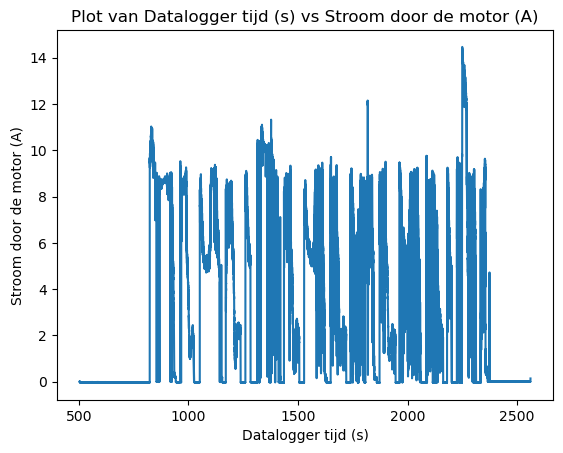

In [12]:
import matplotlib.pyplot as plt
xas= 'Datalogger tijd (s)'
yas= 'Stroom door de motor (A)'
# Maak een plot van kolom 1 (x-as) versus kolom 2 (y-as)
plt.plot(df[xas], df[yas], linestyle='-', markersize=1)

# Labels voor de assen
plt.xlabel(xas)
plt.ylabel(yas)

# Titel van de plot
plt.title(f'Plot van {xas} vs {yas}')

# Toon de plot
plt.show()

#print(df.iloc[:,1]-df.iloc[0,1])